# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [1]:
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib

### Задание 1 (2 балла)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [224]:
import math
def gini(x):
    sum = 0
    classes = np.unique(x)
    for cl in classes:
        cl1 = 0
        cl2 = 0
        for el in x:
            if el == cl:
                cl1+=1
            else:
                cl2+=1
        sum+=cl1*cl2/(len(x)**2)
    return sum
    
def entropy(x):
    sum = 0
    classes = np.unique(x)
    for cl in classes:
        cl1 = 0
        for el in x:
            if el == cl:
                cl1+=1
        p = cl1/(len(x))
        sum+=-p*math.log2(p)
    return sum

def gain(left_y, right_y, criterion):
    node = left_y + right_y
    return criterion(node) - len(left_y)/len(node)*criterion(left_y) - len(right_y)/len(node)*criterion(right_y)

print(gini([1,1,0,0,0,1]))
print(gini([0,0,0,0,0,1]))
print(entropy([1,1,0,0,0,1]))
print(entropy([0,0,0,0,0,1]))
print(gain([0,0,0,0,0,0,0,0,0,0,0], [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], entropy))
print(gain([1,0,0,0,0,0,0,0,0,0,0], [1,0,0,0,0,0,0,0,0,0,0], entropy))

0.5
0.2777777777777778
1.0
0.6500224216483541
0.9575534837147482
0.0


### Задание 2 (2 балла)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [250]:
class DecisionTreeLeaf:
    y = None
    ys = None
    def __init__(self,ys):
#         print(ys)
        self.ys = ys
        tmp,cnt = np.unique(ys, return_counts = True)
        max_i = 0
        max_el = 0
        for i in range(len(cnt)): # Считаем y - преобладающий класс
            if cnt[i] > max_i:
                max_i = cnt[i]
                max_el = tmp[i]
        self.y = max_el

class DecisionTreeNode:
    split_dim = None
    split_value = None
    left = None
    right = None
    def __init__(self):
#         self.split_dim = split_dim
#         self.split_value = split_value
#         self.left = left
#         self.right = right
        pass
        
    def find_best_split_strategy(self,X,y, criterion, depth, min_samples, max_depth):
        max_ig = 0
        best_split_value = 0
        best_split_dim = 0
        found = False
        for split_dim in range(len(X[0])): # Перебираем по чему делить
            min_val = X[0][split_dim]
            max_val = 0
            for i in range(len(X)): # Находим границы
                if X[i][split_dim] > max_val:
                    max_val = X[i][split_dim]
                if X[i][split_dim] < min_val:
                    min_val = X[i][split_dim]
            min_val = int(min_val) - 1
            max_val = int(max_val) + 1
            for split_value in range(min_val, max_val + 1): # Перебираем значения            
                to_left = [y[i] for i in range(len(X)) if X[i][split_dim] < split_value]
                to_right = [y[i] for i in range(len(X)) if X[i][split_dim] >= split_value]
                if len(to_left) < min_samples or len(to_right) < min_samples:
                    continue
                ig = gain(to_left, to_right, criterion) # Считаем IG для нашей комбинации
                if ig>max_ig:
                    max_ig = ig
                    best_split_value = split_value
                    best_split_dim = split_dim
                    found = True
        if not found: # Нет IG, значит надо было делать лист
            return 0
        self.split_value = best_split_value
        self.split_dim = best_split_dim
        to_left = [y[i] for i in range(len(X)) if X[i][best_split_dim] < best_split_value]
        to_right = [y[i] for i in range(len(X))  if X[i][best_split_dim] >= best_split_value]
        X_to_left = [X[i] for i in range(len(X)) if X[i][best_split_dim] < best_split_value]
        X_to_right = [X[i] for i in range(len(X)) if X[i][best_split_dim] >= best_split_value]
        if len(to_left) > min_samples and depth != max_depth - 1:
            self.left = DecisionTreeNode() # Создаем ноду и запускаем рекурсивный подсчет
            if self.left.find_best_split_strategy(X_to_left, to_left,criterion, depth+1, min_samples, max_depth) == 0:
                self.left = DecisionTreeLeaf(to_left) # Не нашли, как поделить, поэтому сделаем лист 
        else:
            self.left = DecisionTreeLeaf(to_left)
        if len(to_right) > min_samples and depth != max_depth - 1:
            self.right = DecisionTreeNode()
            if self.right.find_best_split_strategy(X_to_right, to_right,criterion, depth+1, min_samples,max_depth) == 0:
                self.right = DecisionTreeLeaf(to_right)
        else:
            self.right = DecisionTreeLeaf(to_right)
            
                
            
# DecisionTreeLeaf([1,1,0,1,0,2])

### Задание 3 (6 баллов)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [248]:
class DecisionTreeClassifier:
    criterion = None
    max_depth = None
    min_samples_leaf = None
    root = None
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = DecisionTreeNode()
        if criterion == "gini":
            self.criterion = gini
        elif criterion == "entropy":
            self.criterion = entropy
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    
    def fit(self, X, y):
        # Запускаем рекурсивное построение дерева
        self.root.find_best_split_strategy(X,y,self.criterion, 0,self.min_samples_leaf, self.max_depth)
    
    def predict_proba(self, X):
        res =[]
        for el in X: # Для каждой точки
            vert = self.root
            while not isinstance(vert, DecisionTreeLeaf): # Пока не пришли в лист
                if el[vert.split_dim] < vert.split_value: # Идем по дереву
                    vert = vert.left
                else:
                    vert = vert.right
            els, cnts = np.unique(vert.ys, return_counts = True)
            cnts = [i/len(vert.ys) for i in cnts] # Считаем вероятности
            res.append(dict(zip(els,cnts)))
        return res
            
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [97]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [253]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

Протестируйте решение на данных cancer и spam.

In [237]:
from sklearn.model_selection import train_test_split
import pandas as pd
df = pd.read_csv("cancer.csv")
y = df["label"]
X = df.iloc[:, 1:]
X_train, X_test, y_train, y_test = list(map(lambda x: x.values, train_test_split(X, y, test_size=0.33, random_state=42)))

In [220]:
X_train # Проверяем, что все в порядке

array([[1.546e+01, 1.189e+01, 1.025e+02, ..., 1.827e-01, 3.216e-01,
        1.010e-01],
       [1.285e+01, 2.137e+01, 8.263e+01, ..., 5.601e-02, 2.488e-01,
        8.151e-02],
       [1.921e+01, 1.857e+01, 1.255e+02, ..., 2.091e-01, 3.537e-01,
        8.294e-02],
       ...,
       [1.429e+01, 1.682e+01, 9.030e+01, ..., 3.333e-02, 2.458e-01,
        6.120e-02],
       [1.398e+01, 1.962e+01, 9.112e+01, ..., 1.827e-01, 3.179e-01,
        1.055e-01],
       [1.218e+01, 2.052e+01, 7.722e+01, ..., 7.431e-02, 2.694e-01,
        6.878e-02]])

In [238]:
y_train = pd.get_dummies(y_train)["M"]
y_test = pd.get_dummies(y_test)["M"] # Превращаем игреки в числовые переменные

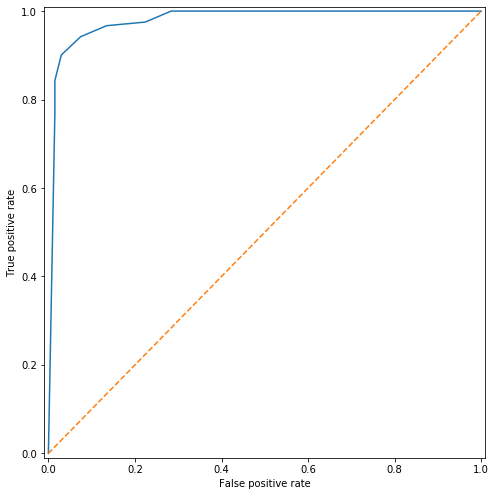

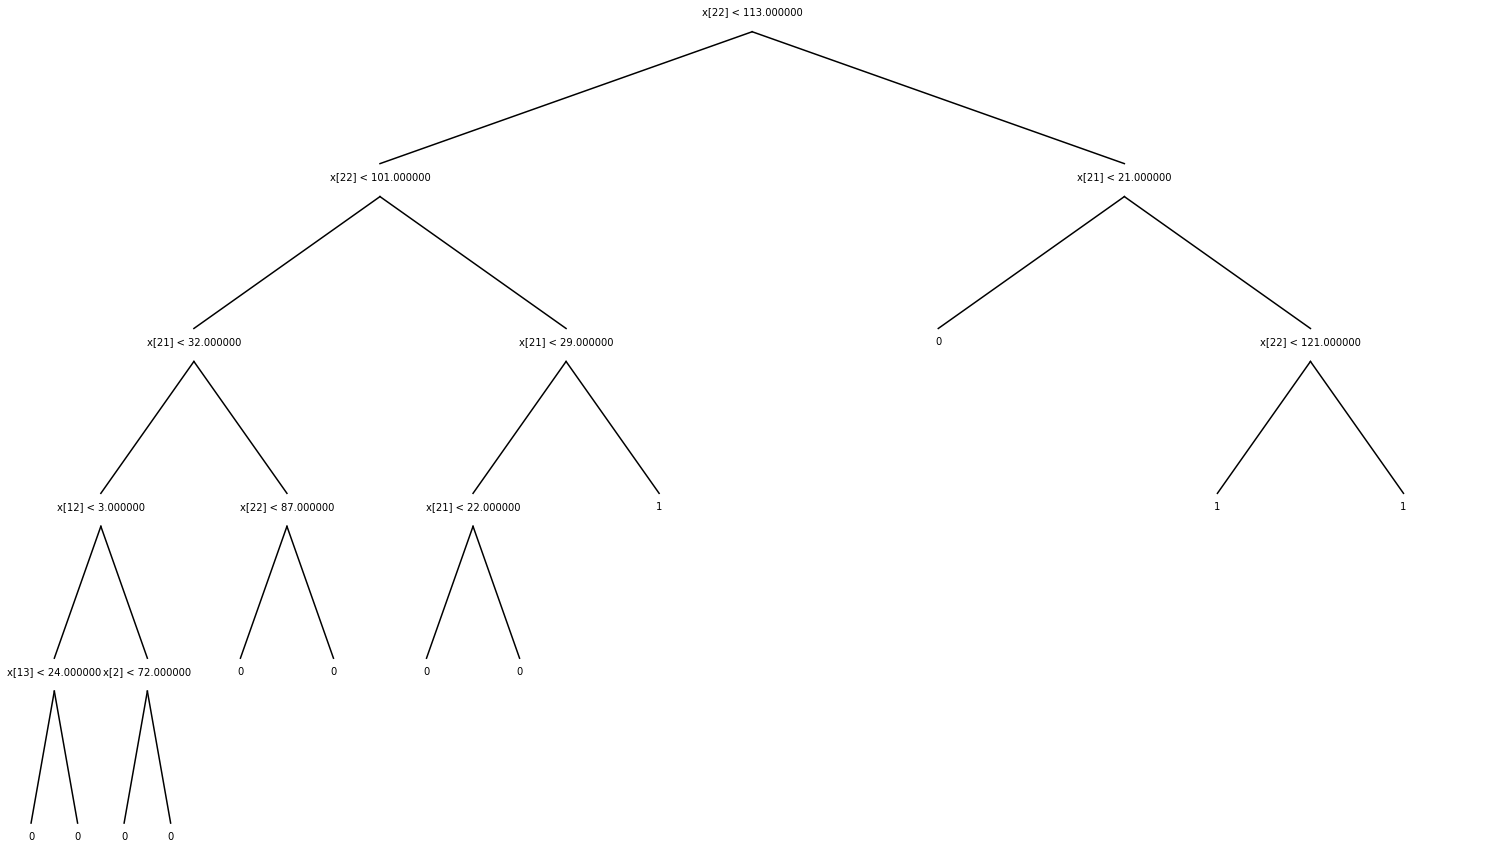

In [254]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)
tree.fit(X_train, y_train)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

In [255]:
df = pd.read_csv("spam.csv")
y = df["label"]
X = df.iloc[:, :-1]
X_train, X_test, y_train, y_test = list(map(lambda x: x.values, train_test_split(X, y, test_size=0.33, random_state=42)))

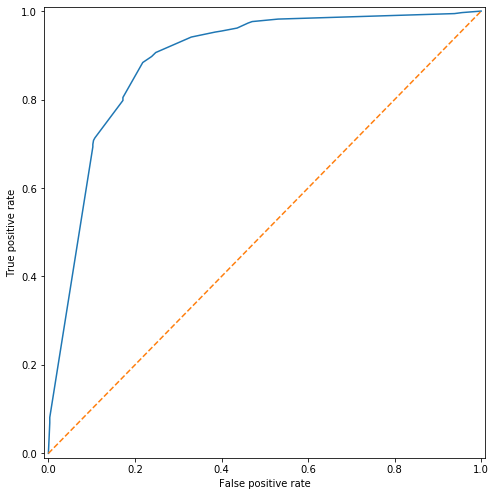

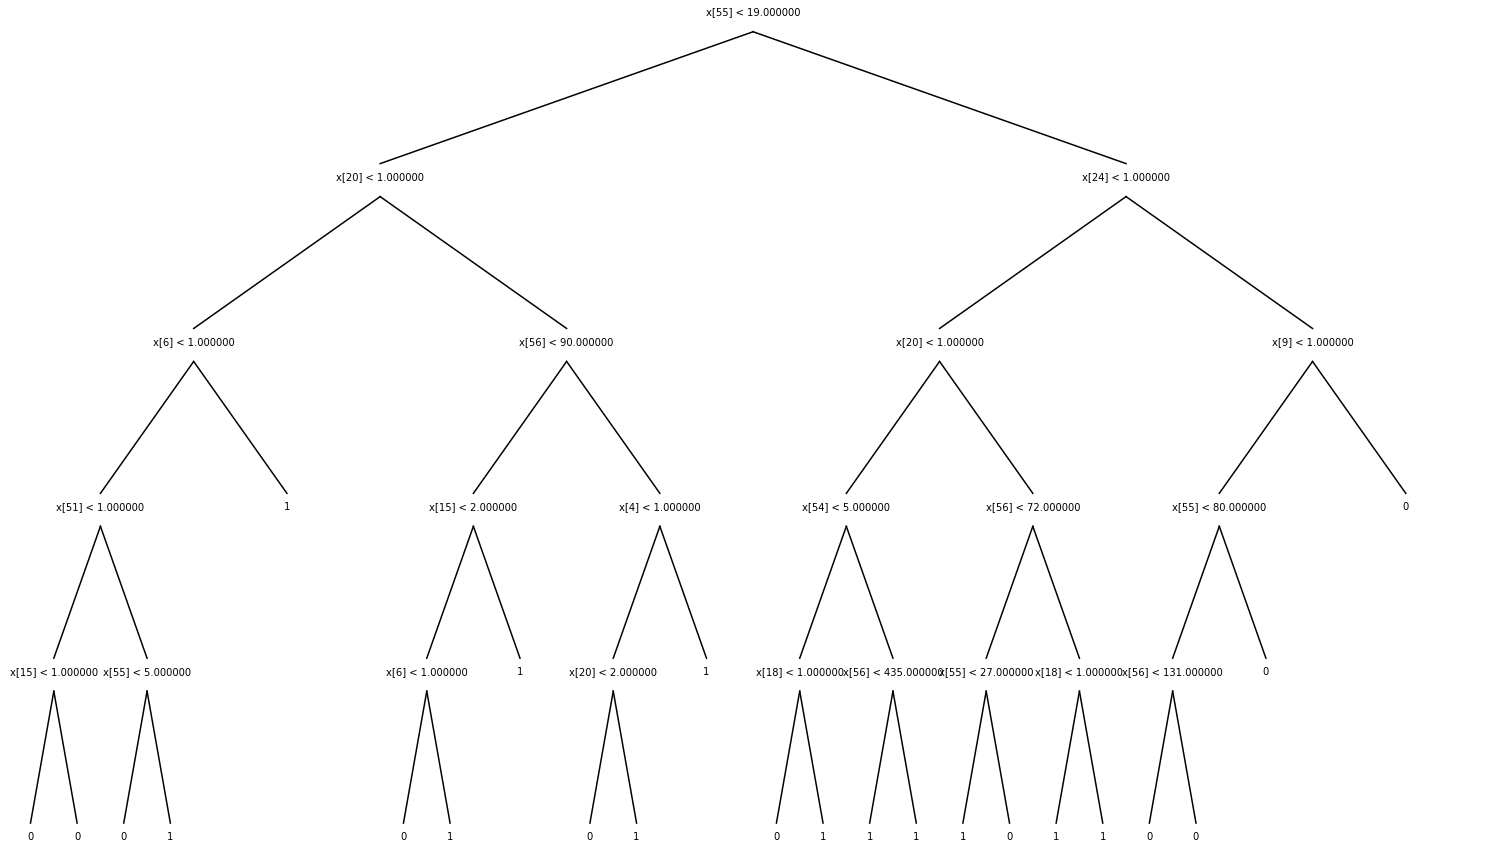

In [256]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)
tree.fit(X_train, y_train)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

In [231]:
df

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_:,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88,0
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14,0
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118,0
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78,0


In [236]:
df.iloc[:,20]

0       0.96
1       1.59
2       0.51
3       0.31
4       0.31
        ... 
4596    0.00
4597    2.00
4598    0.30
4599    0.32
4600    0.65
Name: word_freq_your, Length: 4601, dtype: float64